In [2]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from scipy.spatial import ConvexHull
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from simulation_assembly import MolecularDynamicsSimulation

def extract_features(point_cloud):
    # Center the point cloud
    centroid = point_cloud.mean(axis=0)
    centered_points = point_cloud - centroid

    # PCA-based features
    cov_matrix = np.cov(centered_points.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    eigenvalues = np.sort(eigenvalues)[::-1]  # Sort in descending order

    # Avoid division by zero
    if eigenvalues.sum() == 0:
        pca_ratios = [0, 0, 0]
    else:
        pca_ratios = eigenvalues / eigenvalues.sum()  # Normalize

    aspect_ratios = [
        eigenvalues[0] / eigenvalues[1] if eigenvalues[1] > 0 else 0,
        eigenvalues[1] / eigenvalues[2] if eigenvalues[2] > 0 else 0,
        eigenvalues[0] / eigenvalues[2] if eigenvalues[2] > 0 else 0,
    ]

    # Convex Hull
    try:
        hull = ConvexHull(centered_points)
        hull_volume = hull.volume
        hull_surface_area = hull.area
        compactness = hull_volume / (hull_surface_area ** 3) if hull_surface_area > 0 else 0
    except:
        hull_volume, hull_surface_area, compactness = 0, 0, 0

    # Distribution Features
    try:
        skewness = skew(centered_points, axis=0, nan_policy='omit')
        kurt = kurtosis(centered_points, axis=0, nan_policy='omit')
    except:
        skewness = [0, 0, 0]
        kurt = [0, 0, 0]

    # Point density
    point_density = len(point_cloud) / hull_volume if hull_volume > 0 else 0

    # Feature vector
    features = {
        "eigenvalue_ratio_1": pca_ratios[0],
        "eigenvalue_ratio_2": pca_ratios[1],
        "eigenvalue_ratio_3": pca_ratios[2],
        "aspect_ratio_major_minor1": aspect_ratios[0],
        "aspect_ratio_minor1_minor2": aspect_ratios[1],
        "aspect_ratio_major_minor2": aspect_ratios[2],
        "hull_volume": hull_volume,
        "hull_surface_area": hull_surface_area,
        "compactness": compactness,
        "skewness_x": skewness[0],
        "skewness_y": skewness[1],
        "skewness_z": skewness[2],
        "kurtosis_x": kurt[0],
        "kurtosis_y": kurt[1],
        "kurtosis_z": kurt[2],
        "point_density": point_density,
    }

    return features
def extract_features_from_simulations(input_folder):
    """
    Extract features and labels from simulation files.

    Parameters:
        input_folder (str): Path to the folder containing simulation files.

    Returns:
        tuple: A tuple containing:
            - feature_df (pd.DataFrame): Extracted features as a DataFrame.
            - a_values (list): List of "a" values for coloring.
    """
    all_features = []
    a_values = []

    # Regex patterns for parameter extraction
    a_pattern = re.compile(r"_a([0-9.]+)")

    # Iterate through simulation files
    for filepath in Path(input_folder).glob("*.pkl"):
        try:
            filename_str = filepath.name
            sim_instance = MolecularDynamicsSimulation.load_state(filepath)
            last_state = sim_instance.state_trajectory[-1]
            positions = last_state['positions'][:, 0, :]

            # Extract features
            features = extract_features(positions)
            all_features.append(features)

            # Extract "a" value for coloring
            a_value = float(a_pattern.search(filename_str).group(1))
            a_values.append(a_value)
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")
            continue

    # Convert features to a DataFrame
    feature_df = pd.DataFrame(all_features)
    return feature_df, a_values


def perform_dimensionality_reduction(feature_df):
    """
    Perform t-SNE and UMAP on normalized features.

    Parameters:
        feature_df (pd.DataFrame): Extracted features.

    Returns:
        tuple: A tuple containing:
            - tsne_result (np.ndarray): t-SNE embeddings.
            - umap_result (np.ndarray): UMAP embeddings.
    """
    # Normalize features using StandardScaler
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_df)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    tsne_result = tsne.fit_transform(normalized_features)

    # Perform UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_result = reducer.fit_transform(normalized_features)

    return tsne_result, umap_result



# Usage Example
input_folder = "simulations"
output_folder = "non_linear_dim_red_output"

# Step 1: Extract Features
feature_df, a_values = extract_features_from_simulations(input_folder)

# Step 2: Perform Dimensionality Reduction
tsne_result, umap_result = perform_dimensionality_reduction(feature_df)



Error processing file simulations/20241226165036631697_sim_langevin_dt0.05_a6.0_delta0.024688272691943597_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.005.pkl: Ran out of input
Error processing file simulations/20241218155629047297_sim_langevin_dt0.05_a5.4_delta0.022319667619027553_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.05.pkl: Ran out of input
Error processing file simulations/20241218155629050579_sim_langevin_dt0.05_a5.6_delta0.02311145168201888_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.05.pkl: Ran out of input
Error processing file simulations/20250106195135398734_sim_langevin_dt0.05_a4.8_delta0.019930547129102895_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.005.pkl: Ran out of input
Error processing file simulations/20241218155629007382_sim_langevin_dt0.05_a6.0_delta0.024688272691943597_km0.1_TC20_Bsize20000_damping0.6324555320336759_random0.05.pkl: Ran out of input
Error processing file simulations/20241231052956284335_sim_lange

/home/ckarfusehr/anaconda3/envs/hiv_assembly_3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ckarfusehr/anaconda3/envs/hiv_assembly_3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


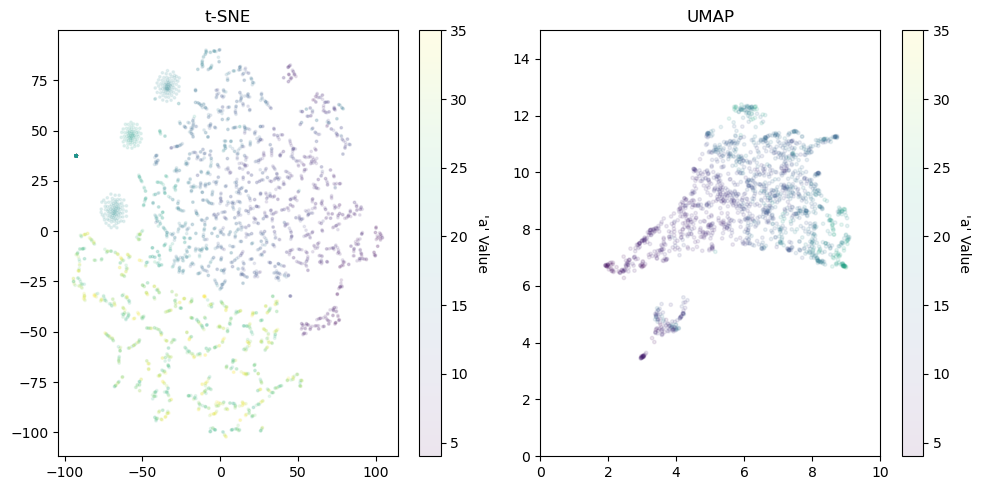

In [10]:

def plot_dimensionality_reduction(tsne_result, umap_result, a_values, output_folder, alpha=0.7, cmap='viridis'):
    """
    Plot t-SNE and UMAP results with coloring based on "a" values.

    Parameters:
        tsne_result (np.ndarray): t-SNE embeddings.
        umap_result (np.ndarray): UMAP embeddings.
        a_values (list): List of "a" values for coloring.
        output_folder (str): Folder to save the plot.
        alpha (float): Transparency of scatter points.
        cmap (str): Colormap for scatter points.
    """
    a_min, a_max = min(a_values), max(a_values)

    plt.figure(figsize=(10, 5))
    # Plot t-SNE results
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=a_values, cmap=cmap, s=3, alpha=alpha)
    cbar = plt.colorbar(scatter)
    cbar.set_label("'a' Value", rotation=270, labelpad=15)
    cbar.set_alpha(1.0)
    #cbar.draw_all()
    plt.title("t-SNE")

    # Plot UMAP results
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=a_values, cmap=cmap, s=6, alpha=alpha)
    cbar = plt.colorbar(scatter)
    cbar.set_label("'a' Value", rotation=270, labelpad=15)
    cbar.set_alpha(1.0)
    #cbar.draw_all()
    plt.title("UMAP")
    plt.xlim(0, 10)
    plt.ylim(0, 15)

    plt.tight_layout()
    output_path = Path(output_folder) / "dimensionality_reduction_scatterplots.pdf"
    plt.savefig(output_path, dpi=300)
    plt.show()


# Step 3: Plot Results
plot_dimensionality_reduction(tsne_result, umap_result, a_values, output_folder, alpha=0.1, cmap='viridis')